1 . import modul

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from datetime import datetime

import math
from datetime import date, timedelta

2. import data

In [7]:
KODE = 'TLKM.JK'
today_date = date.today()
td = timedelta(366)
mulai = today_date - td
end_ = today_date + timedelta(1)

import yfinance as yf

data = yf.download(KODE, start=mulai, end = end_)
datam = yf.download(KODE, period="max", auto_adjust=True)

data.tail()
#datam.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-16 00:00:00+07:00,3800.0,3800.0,3750.0,3770.0,3770.0,49869900
2023-02-17 00:00:00+07:00,3770.0,3770.0,3720.0,3760.0,3760.0,50369000
2023-02-20 00:00:00+07:00,3760.0,3820.0,3760.0,3820.0,3820.0,57438900
2023-02-21 00:00:00+07:00,3850.0,3870.0,3830.0,3840.0,3840.0,63880300
2023-02-22 00:00:00+07:00,3850.0,3870.0,3800.0,3860.0,3860.0,57523100


desc kolom

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2022-02-17 00:00:00+07:00 to 2023-02-16 00:00:00+07:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       247 non-null    float64
 1   High       247 non-null    float64
 2   Low        247 non-null    float64
 3   Close      247 non-null    float64
 4   Adj Close  247 non-null    float64
 5   Volume     247 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.5 KB


3 . Data cleaning

Untuk case ini kita ambil data 1 tahun terakhir (H-365)

4 . Mengecek Stasionary , Seasonality, orde AR, orde MA

4.1 Memecah komponen time series

In [4]:
# Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

data_close= data.filter(['Close'])
data_close



,Close
Date,
2022-02-17 00:00:00+07:00,4410.0
2022-02-18 00:00:00+07:00,4400.0
2022-02-21 00:00:00+07:00,4370.0
2022-02-22 00:00:00+07:00,4300.0
2022-02-23 00:00:00+07:00,4350.0
...,...
2023-02-10 00:00:00+07:00,3800.0
2023-02-13 00:00:00+07:00,3790.0
2023-02-14 00:00:00+07:00,3800.0


C:\Users\User\AppData\Local\Temp\ipykernel_16860\233025279.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_close = data_close[mulai:today_date]


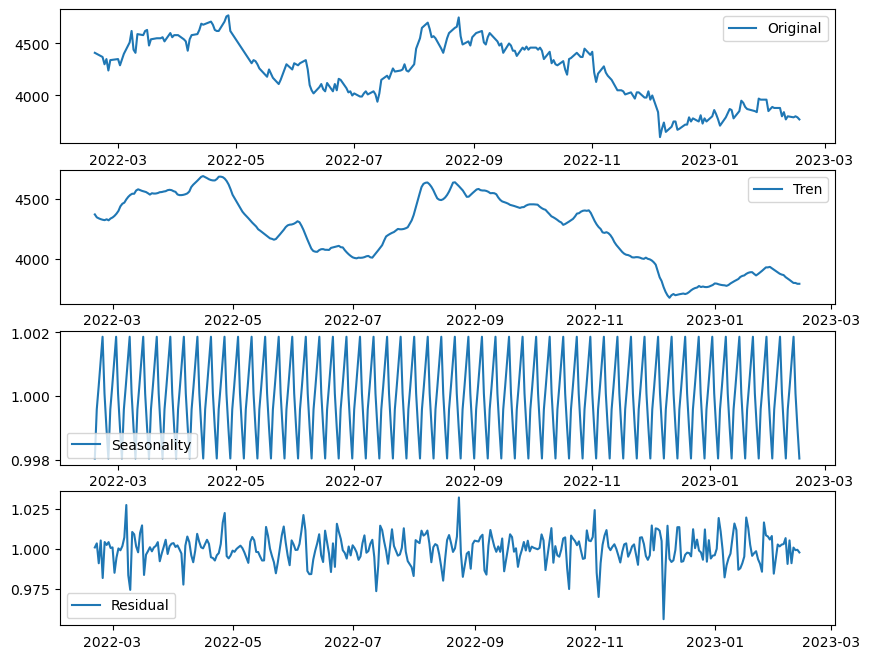

In [5]:
#data_close.index = pd.to_datetime(data['Date'])
data_close = data_close[mulai:today_date]
data_close = data_close.asfreq(freq='D')

data_close.interpolate(inplace=True)


dekomposisi = seasonal_decompose(data_close, model='multiplicative')
trend = dekomposisi.trend
seasonal = dekomposisi.seasonal
residu = dekomposisi.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(data_close, label='Original')
ax[0].legend(loc='best')
ax[1].plot(trend, label='Tren')
ax[1].legend(loc='best')
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend(loc='best')
ax[3].plot(residu, label='Residual')
ax[3].legend(loc='best')
plt.show()

4.2 Stationarity

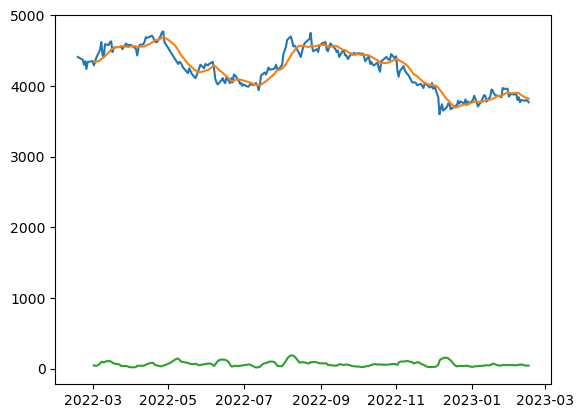

In [6]:
# Kita coba visualisasikan hasil rolling
rollingmean = data_close.rolling(14).mean()
rollingstd = data_close.rolling(14).std()
plt.plot(data_close, label='Original')
plt.plot(rollingmean, label='Mean')
plt.plot(rollingstd, label='std')
plt.show()

Tanpa Augmented Dickey Fuller (adfuller()) test kita bisa lihat data ini ngga stationary. Tapi kita coba adfuller untuk memastikan.

In [7]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

hasil_adfuller = adfuller(data_close.dropna())

print('ADF Statistik: %f' % hasil_adfuller[0])
print(f'p-value: {hasil_adfuller[1]}')

ADF Statistik: -1.254256
p-value: 0.6498321737229951


p-value > 0.05, sekarang kita coba cari orde differencing untuk mencari stationarity

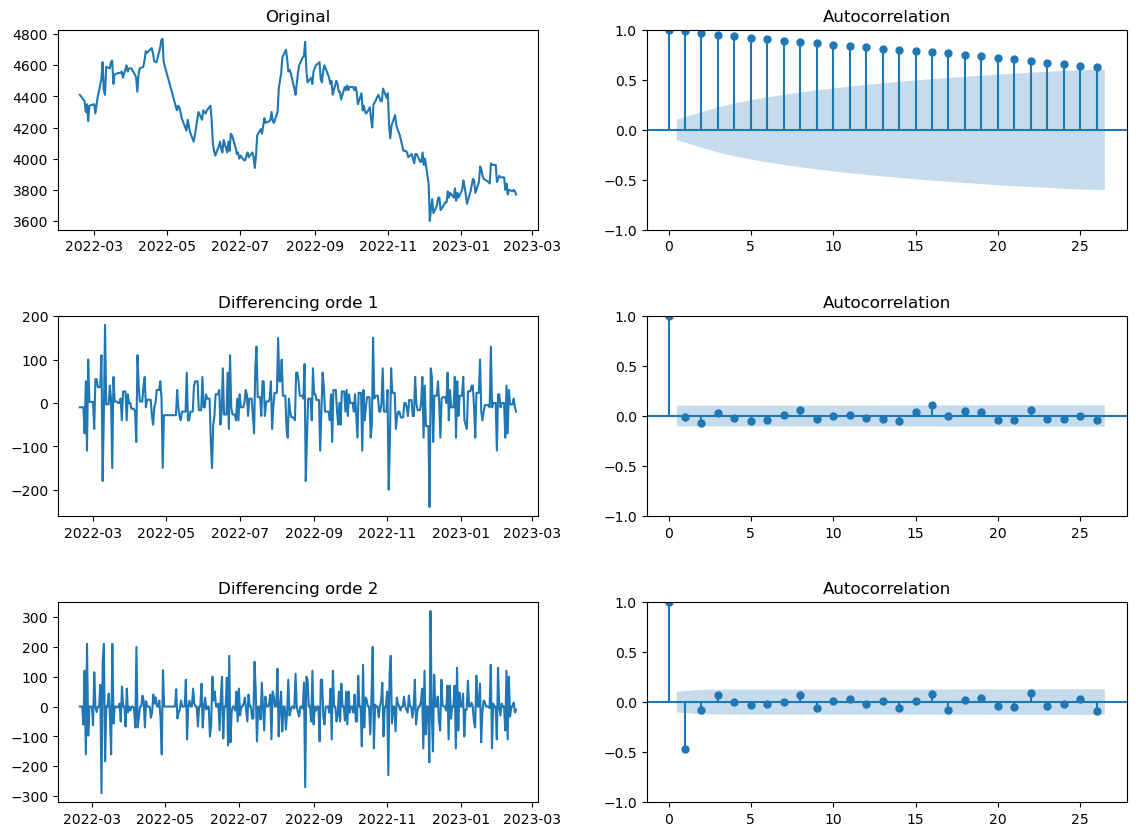

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
axes[0, 0].plot(data_close)
axes[0, 0].set_title('Original')
plot_acf(data_close, ax=axes[0, 1])

axes[1, 0].plot(data_close.diff())
axes[1, 0].set_title('Differencing orde 1')
plot_acf(data_close.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(data_close.diff().diff())
axes[2, 0].set_title('Differencing orde 2')
plot_acf(data_close.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout(pad=3.0)

plt.show()

orde 1 differencing udah bikin time series (TS) stationary. Di autocorrelation plot nya juga udah ok, ngga terlalu cepet menuju negatif.

Autocorrelation plot untuk orde 2 terlalu cepet bikin nilai nya negatif.

Kita pakai d=1 dari hasil ini.

4.3. Menentukan AR lag awal

D:\programs\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


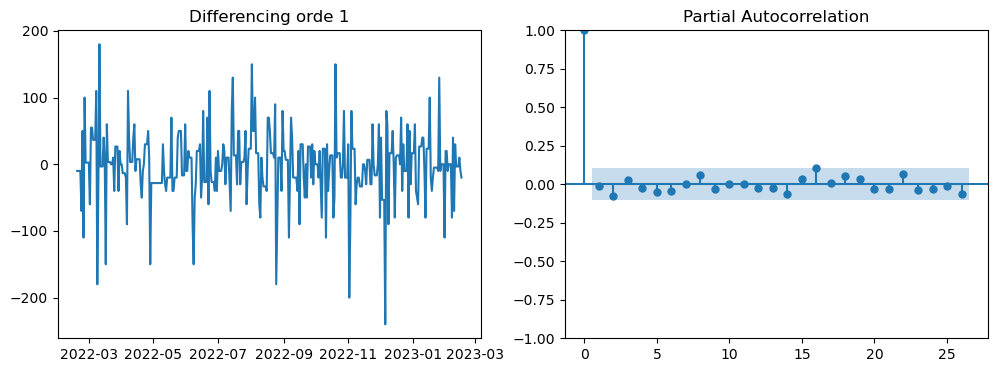

In [9]:
# PACF plot untuk menentukan p (komponen AR)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data_close.diff())
axes[0].set_title('Differencing orde 1')
plot_pacf(data_close.diff().dropna(), ax=axes[1])

plt.show()

4.4. Menentukan MA lag awal

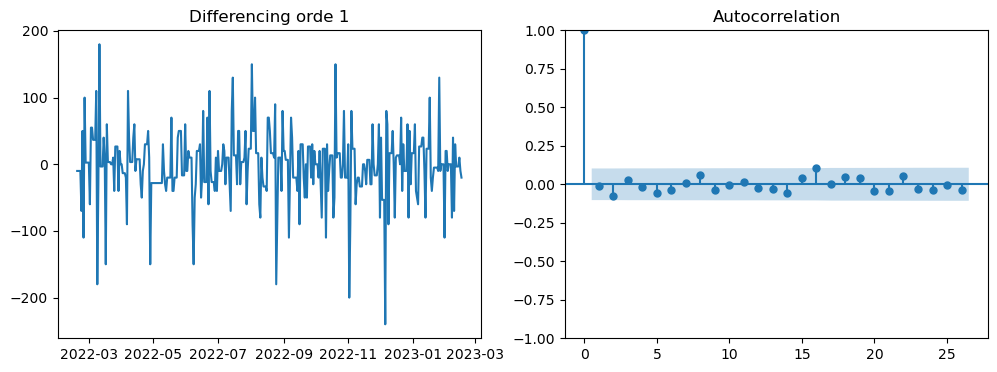

In [10]:
# ACF plot untuk menentukan q (komponen MA)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data_close.diff())
axes[0].set_title('Differencing orde 1')
plot_acf(data_close.diff().dropna(), ax=axes[1])

plt.show()

5. Modelling
5.1. ARIMA model (baseline)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  325
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 977.310
Date:                Sat, 18 Feb 2023   AIC                          -1948.621
Time:                        00:01:35   BIC                          -1937.279
Sample:                    02-20-2022   HQIC                         -1944.094
                         - 01-10-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3994      1.328     -0.301      0.764      -3.003       2.204
ma.L1          0.4295      1.313      0.327      0.744      -2.143       3.002
sigma2         0.0001   6.74e-06     20.821      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               237.79
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.68
Prob(H) (two-sided):                  0.24   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

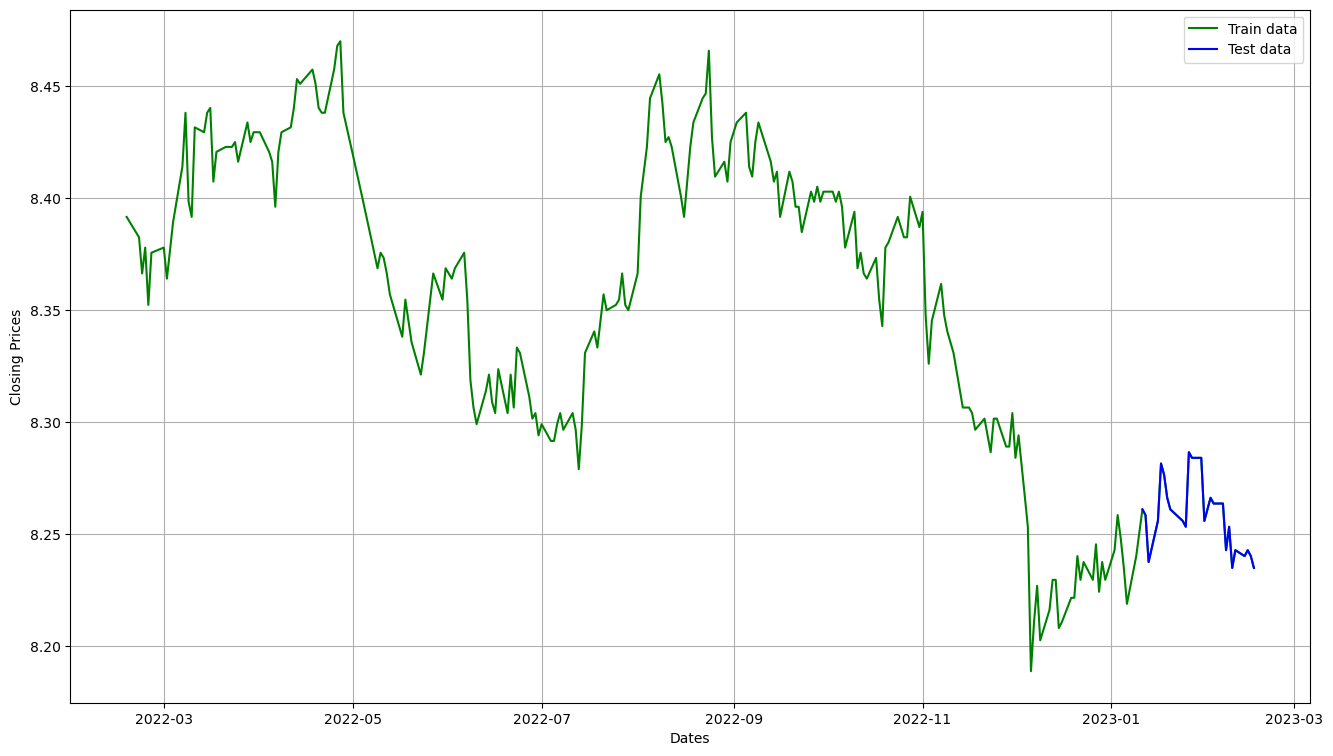

In [11]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

df_log = np.log(data_close)

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
#train_data = data_close[:'2023-01-18']
#test_data = data_close['2023-01-19':]

plt.figure(figsize=(16,9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Model ARIMA (1, 1, 1) langsung ke df
model2 = ARIMA(train_data, order=(1, 1, 1))
model_fit = model2.fit()
model_fit.summary()

tuning

In [12]:
data_close2= data['Close']
data_close2.tail()
df_log2 = np.log(data_close2)

train_data2, test_data2 = df_log2[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

D:\programs\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:203: RuntimeWarning: All-NaN slice encountered
  sample_range = np.nanmax(y) - np.nanmin(y)
D:\programs\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:205: RuntimeWarning: All-NaN slice encountered
  np.nanmin(y) - 0.5 * sample_range,
D:\programs\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:206: RuntimeWarning: All-NaN slice encountered
  np.nanmax(y) + 0.5 * sample_range,


ValueError: `dataset` input should have multiple elements.

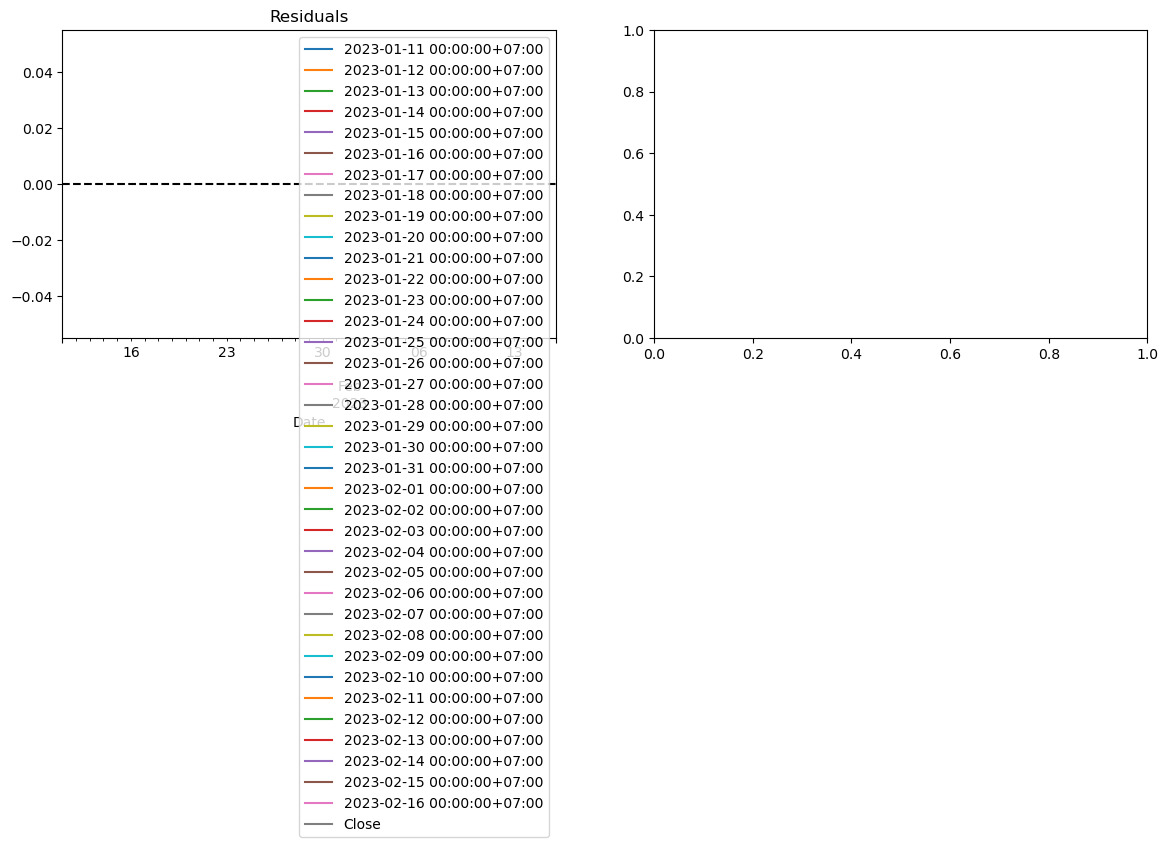

In [13]:
# Plot residual errors
pred = model_fit.predict(test_data2.index[0], test_data2.index[-1])
residuals = test_data2 - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

6. Tuning
   
   6.1. Coba d=2

In [ ]:
# Model ARIMA (1, 2, 1) langsung ke df
model3 = ARIMA(train_data, order=(1, 0, 1)).fit()
model3.summary()

In [ ]:
# Plot residual errors
pred = model3.predict(test_data.index[0], test_data.index[-1])
residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

6.2 Tuning p,d,q menggunakan auto_arima

In [ ]:
# Model ARIMA (p, d, q) menggunakan auto_arima()
import pmdarima as pm

model4 = pm.auto_arima(train_data, start_p=0, start_q=0,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=6,max_d=6, max_q=6,max_P=6 , max_Q=6,max_D=6,
                       m=1, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=False,
                       start_P=0,
                       D=0,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model4.summary()

In [ ]:
# Plot residual errors
pred = model4.predict(len(test_data))
pred = pd.Series(pred, index=test_data.index)

residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

6.3. Memperhitungkan Seasonality, pakai SARIMA

In [ ]:
# Kita coba differencing 28
plt.plot(seasonal[mulai:today_date].diff(28))
plt.show()

In [ ]:
model5 = pm.auto_arima(train_data, start_p=1, start_q=1,
                       test='adf', # pakai adftest untuk mencari 'd' optimum
                       max_p=6,max_d=6, max_q=6,max_P=6 , max_Q=6,max_D=6,
                       m=28, # frekuensi
                       d=None, # model yang akan mencari
                       seasonal=True,
                       start_P=0,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )
model5.summary()

In [ ]:
# Plot residual errors
pred = model5.predict(len(test_data))
pred = pd.Series(pred, index=test_data.index)

residuals = test_data - pred
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
residuals.plot(title='Residuals', ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--', )
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].axvline(0, color='k', linestyle='--')
plt.show()

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

In [ ]:
pred3 = test_data.copy()

for index in tqdm(test_data.index):
    train_data_arima = data_close[:index - timedelta(days=1)]
    
    
    orderku = (1, 2, 1)
    model3 = ARIMA(train_data_arima, order=orderku).fit()
    
    pred = model3.forecast()
    pred3[index] = pred

In [ ]:
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.plot(pred3, label='Prediksi')
plt.legend()
plt.show()

print('MAPE: {}%'.format(round(mape(test_data, pred) * 100, 2)))
print('RMSE:', mse(test_data, pred, squared=False))

Prediksi

In [ ]:
model_final = ARIMA(data_close, order=(1,1,0),seasonal_order=(2, 1, 1, 30)).fit()
# Prediksi Januari Tanggal 1 - 7
jan = model_final.forecast(steps=14)
jan



